# icet tutorial - part 2
Here you will learn how to construct a cluster expansion based on a pre-computed DFT database.    

**Key learning points**
* Cutoff selection
* Training with machine learning algorithms ARDR and RFE
* Validating a cluster expansion - Can you trust it?
* Visualizing a cluster expansion

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ase.db import connect
from icet import ClusterSpace, StructureContainer, ClusterExpansion
from trainstation import Optimizer, CrossValidationEstimator

%matplotlib inline

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print("Don't worry")

## Constructing a cluster expansion
We'll start by going through the basic steps for creating a cluster-expansion.
### Step 1: Connect to reference database
The dft-calculations for the enumerated Ag-Pd structures are found in `reference_data.db`.

In [2]:
db = connect('reference_data.db')
prim = db.get(id=1).toatoms()  # primitive structure
print(prim)

Atoms(symbols='Ag', pbc=True, cell=[[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]])


We plot the mixing energy already stored in the database to get a sense of the dataset.

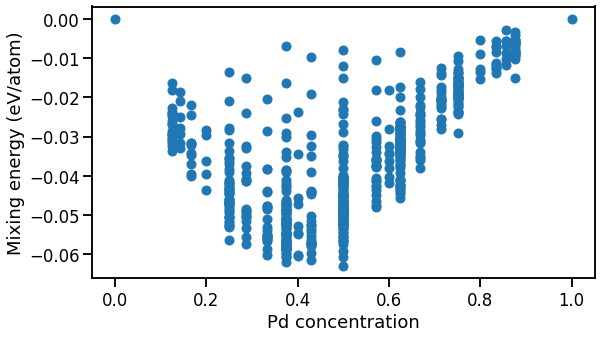

In [3]:
data = []
for row in db.select():
    atoms = row.toatoms()
    c_Pd = atoms.get_chemical_symbols().count('Pd') / len(atoms)
    E_mix = row.mixing_energy
    data.append(dict(c_Pd=c_Pd, E_mix=E_mix))
df = pd.DataFrame(data)

plt.figure(figsize=(9, 5))
plt.plot(df.c_Pd, df.E_mix, 'o')
plt.xlabel('Pd concentration')
plt.ylabel('Mixing energy (eV/atom)')
plt.show()

### Step 2: Construct a ClusterSpace
We start by creating a `ClusterSpace` object which contains the information about the various clusters in our system. To initialize this object we specify a list of cutoffs such as `[8, 5]`, which corresponds to a cutoff of 8 Å for pairs and 5.0 Å cutoff for triplets.

In [4]:
cutoffs = [8, 5]
cs = ClusterSpace(structure=prim, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])
print(cs)

AttributeError: 'OrbitList' object has no attribute 'remove_orbits_with_inactive_sites'

### Step 3: Setup a StructureContainer
Next we'll construct a `StructureContainer` which is initialized with a `ClusterSpace` object. Then we can start adding the training structures to the structure container.

When a `atoms` object is added to a `StructureContainer` the cluster vector for this `atoms` will be computed. The relevant properties of the `atoms` object, in this case the mixing energy, should be added as a dictionary.

The `atoms` object can be assigned a `user_tag` which makes it easy to keep track of structures, here we'll just pass a long the existing `tag` from the database.

In [ ]:
sc = StructureContainer(cluster_space=cs)
for row in db.select():
    properties = {'mixing_energy': row.mixing_energy}
    sc.add_structure(structure=row.toatoms(), user_tag=row.tag, properties=properties)
print(sc)

### Step 4: Training a ClusterExpansion
Once the structure container is finished the training can begin. The ECIs (model parameters) are found by solving the linear problem $\boldsymbol{A}\boldsymbol{J} = \boldsymbol{E}$, where $\boldsymbol{A}$ is the sensing (design) matrix, $\boldsymbol{J}$ the ECIs and $\boldsymbol{E}$ the target energies.


The training is here done with the python package [trainstation](https://trainstation.materialsmodeling.org/)  which provides various training methods and cross-validation techniques via [sklearn](https://scikit-learn.org/).

Here we'll use the `CrossValidationEstimator` to train the model and also get a CV-score in order to evaluate the accuracy of the cluster expansion.

In [ ]:
A, y = sc.get_fit_data(key='mixing_energy')
cve = CrossValidationEstimator(fit_data=(A, y), fit_method='least-squares')
cve.validate()
cve.train()
print(cve)
ce = ClusterExpansion(cluster_space=cs, parameters=cve.parameters)

Printing the `CrossValidationEstimator` provides a lot of useful information, such as the training and validation root mean squared errors (rmse).

In order to get a better feel for the error we plot the target vs predicted energies for the validation set.

In [ ]:
sd = cve.scatter_data_validation

lim = [sd.target.min()-0.01, sd.target.max()+0.02]

plt.figure(figsize=(6, 5))
plt.plot(lim, lim, '-k')
plt.plot(sd.target, sd.predicted, 'o', alpha=0.2, mec='none')
plt.xlim(lim)
plt.ylim(lim)

plt.xlabel('Target (eV/atom)')
plt.ylabel('Predicted (eV/atom)')
plt.show()

### Step 5: Visualize ECIs 
The ECI data can be obtained from a `ClusterExpansion` as a pandas dataframe via

In [ ]:
df = ce.to_dataframe()
print(df[['order', 'radius', 'eci']])

To plot the ECIs we use the built in utility function for plotting the ECIs.

In [ ]:
orders = df.order.unique()

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
ax.axhline(y=0.0, c='k', lw=1)
for order in orders:
    df_order = df.loc[df['order'] == order]
    ax.plot(df_order.radius, df_order.eci, 'o', label='order {}'.format(order))
ax.legend(loc='best')
ax.set_xlabel('Cluster radius (Å)')
ax.set_ylabel('ECI (eV/atom)')
plt.show()

# Cutoff selection
In the previous steps we simply selected some arbitrary cutoff radius for the pairs and triplets, here we will explore if we can make a more educated guess of the optimal cutoffs.

Each cutoff will result in a different cluster space and thus also a different structure container and since we want to test many cutoffs it is useful to create helper functions for creating cluster space and structure containers based on the cutoff.

In [ ]:
def get_cluster_space(cutoffs):
    """Returns the cluster space for a corresponding cutoffs"""
    prim = db.get(id=1).toatoms()  # primitive structure
    cs = ClusterSpace(structure=prim, cutoffs=cutoffs, chemical_symbols=['Ag', 'Pd'])
    return cs

def get_structure_container(cutoffs):
    cs = get_cluster_space(cutoffs)
    sc = StructureContainer(cs)
    for row in db.select('natoms<=8'):
        sc.add_structure(structure=row.toatoms(), user_tag=row.tag,
                         properties={'mixing_energy': row.mixing_energy})
    return sc

It would also be useful that we can, for a given structure container, get the fitting data.

opt.summary is a dictionary with most of the useful fitting information

In [ ]:
def get_fitting_summary(structure_container, fit_method='rfe'):
    """Returns the fitting summary for a given structure container"""
    opt = CrossValidationEstimator(fit_data=structure_container.get_fit_data(key='mixing_energy'),
                                   fit_method=fit_method)
    opt.validate()
    opt.train()

    summary = dict(fit_method=fit_method)
    summary['n_parameters'] = opt.n_parameters
    summary['n_nonzero_parameters'] = opt.n_nonzero_parameters
    summary['rmse_train'] = opt.rmse_train
    summary['rmse_validation'] = opt.rmse_validation
    return summary

Now we are ready for business!    
We can now loop over e.g. pair cutoffs and get the CV-RMSE scores.
We'll also consider two different fit methods, ordinary least squares and automatic relevance determination regression (ARDR). See [icet userguide](https://trainstation.materialsmodeling.org/moduleref.html) for more information about the various available fit methods.

In [ ]:
fit_methods = ['ardr', 'least-squares']
fitting_data = []
for pair_cutoff in np.arange(3, 12, 1):
    cutoffs = [pair_cutoff]
    sc = get_structure_container(cutoffs)
    for fm in fit_methods:
        summary = get_fitting_summary(sc, fit_method=fm)
        summary['pair_cutoff'] = pair_cutoff
        fitting_data.append(summary)
df = pd.DataFrame(fitting_data)

Next the validation RMSE scores are plotted as a function of cutoff to determine a good choice of cutoff.

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

for fm in fit_methods:
    df_fm = df[df['fit_method'] == fm]
    plt.plot(df_fm.pair_cutoff, df_fm.rmse_validation*1e3, label='validation score {}'.format(fm))

ax.set_xlabel('Pair cutoff (Å)')
ax.set_ylabel('RMSE error (meV/atom)')
ax.legend(loc=1)
plt.show()

We note that there is no real difference between the two fit methods.   
We select the pair cutoff of 8 Å based on the results above.

Next we'll use the same procedure to determine the third-order cutoff.

In [ ]:
cutoffs = [8, 0]
fitting_data = []
for triplet_cutoff in np.arange(4, 9, 1): # triplet cutoff loop
    cutoffs[1] = triplet_cutoff
    sc = get_structure_container(cutoffs)
    for fm in fit_methods:
        summary = get_fitting_summary(sc, fit_method=fm)
        summary['triplet_cutoff'] = triplet_cutoff
        fitting_data.append(summary)
df = pd.DataFrame(fitting_data)

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

for fm in fit_methods:
    df_fm = df[df['fit_method'] == fm]    
    plt.plot(df_fm.triplet_cutoff, df_fm.rmse_validation*1e3, '-o',label='validation score {}'.format(fm))
ax.set_xlabel('Triplet cutoff (Å)')
ax.set_ylabel('RMSE error (meV/atom)')
ax.legend(loc=1)
plt.show()

For third-order clusters we select a cutoff of 6Å. Here we stop with the cutoff selection but in principle the same can be done for the higher order clusters.
One could also re-iterate and go back to pair cutoff selection with the selected triplet cutoff.

Finally we'll construct a learning curve, meaning rmse vs number of training structures curve, using the finalized cutoffs of 8Å and 6Å for pair and triplets respectively.

A learning curve can help understand how well converged the cluster expansion is with respect to number of training structures.


In [ ]:
learning_curve_data = []
final_cutoffs = [8, 6]
sc = get_structure_container(final_cutoffs)

for train_size in np.arange(50,len(sc)-100,50):
    for fm in fit_methods:
        cve = CrossValidationEstimator(fit_data=sc.get_fit_data(key='mixing_energy'),
                                       fit_method=fm, validation_method='shuffle-split',
                                       train_size=train_size, # adjust training size
                                       test_size=len(sc)-train_size) # test size is the remaining structures
        cve.validate()
        cve.train()
        summary = cve.summary
        learning_curve_data.append(summary)
df = pd.DataFrame(learning_curve_data)

Now plot the learning curve

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1,1,1)

ax1.set_xlabel('Number of training structures')
ax1.set_ylabel('RMSE error (meV/atom)')

for fm in fit_methods:
    df_fm = df[df['fit_method']==fm]    
    ax1.plot(df_fm.train_size, df_fm.rmse_validation * 1e3, '-o',label='validation score {}'.format(fm))
ax1.legend()

From this we can tell that using ~300 training structures or 500 does not make a big impact, indicating the the cluster expansion is converged.

We can also note that when using small numbers of training structures least-squares tends to overfit, and ARDR yields better accuracy.